# 第2回：株価を予測しよう
## 問題設定

ある株価に注目した時、過去３日分の株価の始値、高値、安値、終値から、今日の株価が上がるか下がるか（つまり今日の終値は今日の始値より高くなったか）をランダムフォレストと呼ばれる機械学習のアルゴリズムにより予測しましょう。  

もちろん、そんな少ないデータで予測できるわけがありませんよね。ですが、過去1年間分のデータを使うとか、ドル/ユーロ為替レートの情報を追加するとか、その日のお天気情報を追加するとか、その日の新聞の頻出単語ベクトルを追加するなんてことは、この延長線上にありますので、まずは簡単な条件から始めましょう。

## 1. 株式データの取得：株式データの読み込み

まずデータを読み込みましょう。  
このデータは2018年1月1日～2019年3月31日までの米国でのトヨタの株価データです。

In [1]:
import pandas as pd

df = pd.read_csv('TM_20180101-20190331_stock.csv')
df['date'] = pd.to_datetime(df['date']) # 'date'キーの値は日付を表す文字列なので、to_datetimeを適用してdatetime64型に変換
df.set_index('date', inplace=True) # 次に、set_index()メソッドで'date'キーの列をインデックスに指定する。
df.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,123.4915,124.4606,123.2396,124.4025,83545
2018-01-03,124.7029,126.2104,124.5866,126.1081,162349
2018-01-04,127.2516,128.0754,127.2419,128.0754,161798
2018-01-05,128.9960,129.7325,128.9669,129.7228,135309
2018-01-08,129.8391,130.6241,129.4902,130.6047,131364


volumeだけは単位が異なるので今回は除去しておきます。

In [2]:
df2 = df.drop('volume', axis=1)
df2.head()

,open,high,low,close
date,,,,
2018-01-02,123.4915,124.4606,123.2396,124.4025
2018-01-03,124.7029,126.2104,124.5866,126.1081
2018-01-04,127.2516,128.0754,127.2419,128.0754
2018-01-05,128.9960,129.7325,128.9669,129.7228
2018-01-08,129.8391,130.6241,129.4902,130.6047


## 2. 前処理

機械学習は文字通り機械が学習するわけですが、じゃあ人間はデータを機械に渡して終わりなのかといえばそんなことはなく、機械学習を用いてビッグデータを分析するデータアナリストと呼ばれる人たちも、実に仕事の時間の80～90%の時間を前処理についやしています。   
この前処理では、ノイズや欠落のあるデータを取り除く「クリーニング」と呼ばれる作業や、   
パラメータによってスケールがバラバラなものを統一する「標準化・正規化」などが含まれ、   
前処理をどれだけ精魂込めてやったかどうかが、最終的な精度に大きく影響すると言われてます。

以下の正規化は、株価では必ずこうしなければならないというわけではなく、一つのやり方にすぎません。   
興味のある方は是非いろいろと工夫してみてください。


### 2.1 株価の上昇・下落を比率に変換

お金の価値は不変ではなくその日その日で変わりますし、絶対値が重要ではないと考えられます。   
そこで、open, high, lowをcloseで割って比率で表すことにします。   
またこうすると、closeはその日の基準値ですから除去（drop)しましょう。   
さらに、過去3日分を考慮するため、もう2日分のデータを追加しましょう。

なお、行の値を一つずらすには`shift(ずらす数)`というメソッドを使用します。

In [3]:
df3 = pd.DataFrame()
df3['open'] = df2['open'] / df2['close']
df3['high'] = df2['high'] / df2['close']
df3['low'] = df2['low'] = df2['close']
df3['open-1'] = df3.shift()['open']
df3['high-1'] = df3.shift()['high']
df3['low-1'] = df3.shift()['low']
df3['open-2'] = df3.shift(2)['open']
df3['high-2'] = df3.shift(2)['high']
df3['low-2'] = df3.shift(2)['low']

df3.head()

,open,high,low,open-1,high-1,low-1,open-2,high-2,low-2
date,,,,,,,,,
2018-01-02,0.992677,1.000467,124.4025,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.988857,1.000811,126.1081,0.992677,1.000467,124.4025,NaN,NaN,NaN
2018-01-04,0.993568,1.000000,128.0754,0.988857,1.000811,126.1081,0.992677,1.000467,124.4025
2018-01-05,0.994397,1.000075,129.7228,0.993568,1.000000,128.0754,0.988857,1.000811,126.1081
2018-01-08,0.994138,1.000149,130.6047,0.994397,1.000075,129.7228,0.993568,1.000000,128.0754


### 2.2 翌日、上昇したかを表す行を追加

ランダムフォレストは、クラスタリングのアルゴリズムです。   
つまり、あらかじめ定めたいくつかのクラスのうち、どのクラスに属するかを推定する手法です。   

今回知りたいのは翌日上昇したかどうかです。   
上昇したなら`1`、下落あるいは同じならば`0`として、2クラス分類の問題をランダムフォレストで解くことにしましょう。   
（上昇率に0.01%などのレンジを設けて、それ以上、上昇したら`1`、それ以上、下落したら`-1`、どちらでもなければ`0`とし、3クラス分類を解いてもいいでしょう。）

翌日、上昇したかしなかったかを`1`または`0`の二値で判定し、その値をラベルとして`updown`というキーの列に追加したいと思います。   
これは、各行について、翌日のclose/openを計算し、その値が1より大きいならば1、そうでなければ0とすればいいですね。 

In [4]:
df3['updown'] = (1/df3['open'].shift(-1) > 1 ).astype(int)
df3 = df3.dropna() # NaN (Not a Numer)が含まれているデータは除去
df3.head()


,open,high,low,open-1,high-1,low-1,open-2,high-2,low-2,updown
date,,,,,,,,,,
2018-01-04,0.993568,1.000000,128.0754,0.988857,1.000811,126.1081,0.992677,1.000467,124.4025,1
2018-01-05,0.994397,1.000075,129.7228,0.993568,1.000000,128.0754,0.988857,1.000811,126.1081,1
2018-01-08,0.994138,1.000149,130.6047,0.994397,1.000075,129.7228,0.993568,1.000000,128.0754,0
2018-01-09,1.000749,1.000823,129.5871,0.994138,1.000149,130.6047,0.994397,1.000075,129.7228,0
2018-01-10,1.002419,1.006525,132.1843,1.000749,1.000823,129.5871,0.994138,1.000149,130.6047,1


ここで一旦csvファイルとして記録しておきましょう。

In [5]:
df3.to_csv('stock_train_dataset.csv')

その日、前日、前々日の`open`, `high`, `close`の3つの値から、`updown`がTrueかFalseかを予測する問題になります。

このファイルを読み込むには以下のようにしてください。

In [6]:
import pandas as pd

df = pd.read_csv('stock_train_dataset.csv')
df['date'] = pd.to_datetime(df['date']) # 'date'キーの値は日付を表す文字列なので、to_datetimeを適用してdatetime64型に変換
df.set_index('date', inplace=True) # 次に、set_index()メソッドで'date'キーの列をインデックスに指定する。
df.head()


,open,high,low,open-1,high-1,low-1,open-2,high-2,low-2,updown
date,,,,,,,,,,
2018-01-04,0.993568,1.000000,128.0754,0.988857,1.000811,126.1081,0.992677,1.000467,124.4025,1
2018-01-05,0.994397,1.000075,129.7228,0.993568,1.000000,128.0754,0.988857,1.000811,126.1081,1
2018-01-08,0.994138,1.000149,130.6047,0.994397,1.000075,129.7228,0.993568,1.000000,128.0754,0
2018-01-09,1.000749,1.000823,129.5871,0.994138,1.000149,130.6047,0.994397,1.000075,129.7228,0
2018-01-10,1.002419,1.006525,132.1843,1.000749,1.000823,129.5871,0.994138,1.000149,130.6047,1


### 3. 学習データを分割

精度評価は、「いくつ中いくつが当てられたか？（パーセント）」で行いましょう。

ここで、得られたデータをすべて使って学習していいでしょうか？   
（基本的には）ダメです。

- Closed test: モデルを学習したデータと同じデータセットで精度を評価すること   
    - 当然高い精度が出るが、未知のデータに対する予測性能を意味しない
    - ここで精度が低ければ見込みなしともいえる
- Open test: モデルを学習するデータとは違うデータで評価する  
    - 与えられたデータをあらかじめ学習データ(training data)と評価データ(test data)にわけ、学習データでモデル学習して評価データで評価  
    - 未知のデータに対する予測性能の評価が可能
    - Closed testの精度は非常に高いが、Open testの精度が低いとき、過学習と呼ぶ
    
通常は**Open test**で評価します。   
それでは、学習データと評価データをどう分けたらいいでしょうか？
- 学習データが小さければ小さいほどモデルの性能は下がります
- 一方で、評価データが小さいと、異常値（Outlier)に引きずられます

今回は学習データ：評価データ＝7:3で分割することにします。   
これにはsklearn.model_selection.train_test_splitという関数を使います。   
データは全部で310個なので、学習データが217個、評価データが93個です。

なお、交差検定法を使うのが一般的です（今回はやりません）。


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.loc[:,['open', 'high', 'low', 'open-1', 'high-1', 'low-1', 'open-2', 'high-2', 'low-2']], 
                                                    df['updown'], 
                                                    random_state=0,
                                                    test_size=0.3)
print('学習データサイズ：', len(X_train), '\t評価データサイズ：', len(X_test))


学習データサイズ： 217 	評価データサイズ： 93


### 4. 学習

今回は学習アルゴリズムとしてランダムフォレストを使います。   
ランダムフォレスト（ランダムな森）は、まず与えられた学習データから、ランダムな条件で沢山のサブセットを生成します。   
このとき、ランダムな条件とは、使う学習データの組み合わせを変えたり、説明変数の組み合わせを変えたりすることです。   
こうして得られたそれぞれのサブセットから1つずつ決定木を生成します。   
判定に際しては、与えられたデータに対して各決定木にそれぞれ判定結果をださせ、その中で多数決をとることにより、最終的な結果を判定します。

scikit-learnのRandomForestClassifierでは、以下のようなパラメータを設定することができます。

- n_estimators：決定木の数。デフォルトは10
- max_features：それぞれの木で使用する説明変数の数。デフォルトは説明変数の種類数の平方根。大きいとどの木も同じような説明変数を使うことになるため、多様性が生まれない。一方、小さいと、説明変数が不十分で決定木の性能が落ちる。
- random_state：乱数を制御するパラメータ。指定しないと毎回結果が変わる。整数をシードとして渡すと毎回同じ結果になる。
- max_depth：決定木の深さ。デフォルトは10。

他にもあります。詳しくは[こちら](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)を参照。

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 5. 評価

データに付けられている正と負をそれぞれTrueとFalse、  
判別モデルが出した答えの正解・不正解をそれぞれPositiveとNegativeと呼びます。

予測が成功するパタンと失敗するパターンは以下の4つがあります。
- 株価が上がり（True）、判別モデルも上がる（Positive)と予想した(True Positive, TP) --> 予測成功！
- 株価が下がり（False)、判別モデルも下がる（Negatie)と予想した（False Netagive, FN)--> 予測成功！
- 株価が上がった（True）けど判別モデルは下がる（Negative)と予想した(True Negative, TN) --> 予測失敗
- 株価が下がった（False）けど判別モデルは上がる（Positive)と予想した(False Positive, FP) --> 予測失敗

正解率 (accuracy)は次のようにして行います。

$$ \mbox{accuracy} = \frac{\mbox{TP}+\mbox{TN}}{\mbox{TP} + \mbox{FP} + \mbox{TN} + \mbox{FN}}$$

下の評価で、model.scoreは正解率の平均（mean accuracy)を出力しています。

また、機械学習を用いたクラス分類の精度を評価するには、混同行列 (Confusion matrix) を作成して、正しく識別できた件数、誤って識別した件数を比較することが一般的です。  
今回は２値分類ですので、混合表列は下の図のような関係の2×2の行列です。   
<img src="fig/ConfusionMatrix.png" width=300>    
各要素はTP/FN/TN/FPの数を表しています。   
評価データが93個ありますので、4つの要素の合計は93になります。


In [9]:
from sklearn.metrics import confusion_matrix

# 評価
print('Closed test score: {}'.format(model.score(X_train, y_train))) # 学習データと同じデータで評価した場合の精度
print('Open test score: {}'.format(model.score(X_test, y_test))) # 学習データとは別のデータで評価した場合の精度
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, model.predict(X_test)))) # 混合行列

Closed test score: 0.9907834101382489
Open test score: 0.4838709677419355
Confusion matrix:
[[33 18]
 [30 12]]


株取引で稼ぐためには精度が0.5を超えないと使えないわけですが、精度は0.5を超えられたでしょうか？   
でもちょっと待ってください。ランダムフォレストは途中、ランダムに行う作業があるので、   
「5. 学習」からここまでを実行するたびに、毎回違う答えが出てくるはずです。  
0.5を超えることもあれば、超えないこともあります。やはりこの程度ではお金儲けは難しそうですね。


### おまけ：各特徴量の重要度を算出する

決定木は、根（ルート）からはじめ、節（ノード）に設定された条件（条件は特定の説明変数に対して与えられる）によってデータを徐々に細分類していく手法です。   
このとき、根に近い上流に設定された条件ほど重要となるように生成されます。   
このとき、重要とは、データを、理想的には半分に分類する条件です。   
なぜならば、ひとまとまりのデータを二つに分けるとき、真っ二つに割るのが最も候補の最大値を減らすことができるからです（片方の候補がすくないと、もう片方の候補は多いということになりますよね）。   

それでは、各説明変数は、総じてどの程度候補を減らすことができたのでしょうか？  
それをもって、その説明変数がどれだけ重要かを測ることができそうです。   
scikit-learnのRandomForestClassifierで学習したモデルは、.feature_importances_という変数に、各説明変数の重要度が保存されています。  
これを棒グラフで可視化してみましょう。どの説明変数が最も予測するのに重要だったのでしょうか？   
（ただし、上で説明した通り、ランダムフォレストは毎回答えが変わります。今回のように精度が低い場合は、そもそもこれらの説明変数で事象をうまく説明できていないので、重要度もあてにならない可能性が高いです。）

([<matplotlib.axis.YTick at 0x11f7051d0>,
 <a list of 9 Text yticklabel objects>)

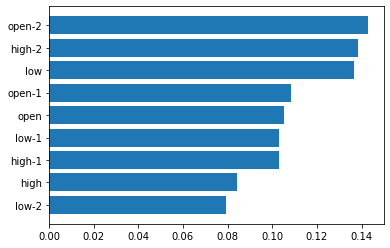

In [10]:
%matplotlib inline
import matplotlib.pyplot as pyplot

values, names = zip(*sorted(zip(model.feature_importances_, ['open', 'high', 'low', 'open-1', 'high-1', 'low-1', 'open-2', 'high-2', 'low-2'])))

pyplot.figure()
pyplot.barh(range(len(names)), values, align='center')
pyplot.yticks(range(len(names)), names)